In [1]:
import ArticleComparator as ac
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup
import csv 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from Helper import *
from Helper import update_links_df_position
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")

from graph import Graph

### **1. Intruduction :**


Todo copy intro from data story 

---
---

### **2. Common Gence Graph Vs Truth Graph**

In [2]:
truth_graph = Graph()
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
truth_graph.update_graph("data/links.tsv", mode='g', verbose=True)

In [3]:
cs_graph = Graph()
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=False) 
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True) 

---
---

### **3. The semantic's bias on path choice :**


The idea behind this this part is to understand how people hwo won the game did to navigate through this huge graph. <br>
More specifically we will try to see how semantic did influnce the chosen paths by comparing them to optimal paths. <br>

To do so we will perform two tasks : <br>
1. First we will try to find the optimal path for each node in the graph using Dijkstra algorithm. <br>

2. Then we will compare semantic similarity over the optimal path and the one chosen by a player. <br>

##### **3.1. Finding the optimal path for each node in the graph using Dijkstra algorithm :** <br>

###### Todo wait for youssef

##### **3.2. Compare semantic similarity over the optimal path and the one chosen by a player :** <br>

We first start by creating a dataframe `df_paths_finished` that contains all the finished paths.
The data frame will have 4 entries at this stage :
- `path` : which is the list of nodes that the player went through
- `start` : the starting node
- `end` : the ending node
- `length` : the length of the path

However we will discard paths where backclicking is done.

In [4]:
df_paths_finished = create_paths_finished_df()
df_paths_finished.sample(5)

Discarded paths due to backclicks:  9052
Number of paths retained:  42266


,path,start,end,length
20230,"[Kubla_Khan, Genghis_Khan, History, Anthropology]",Kubla_Khan,Anthropology,4
17338,"[Pyramid, France, World_War_II, Adolf_Hitler]",Pyramid,Adolf_Hitler,4
180,"[Africa, Europe, United_Kingdom, England]",Africa,England,4
6272,"[Shark, Australia, Football_%28soccer%29, FIFA]",Shark,FIFA,4
36065,"[Nahuatl_language, Spanish_language, Spain, La...",Nahuatl_language,Telescope,8


For obvious reasons we will also discard trivial paths (length 1)

In [5]:
print("Number of trivial paths: ", len(df_paths_finished[df_paths_finished['length'] == 1]))
df_paths_finished = df_paths_finished[df_paths_finished['length'] > 1]

Number of trivial paths:  11


Similarly we create a dataframe `df_paths_optimal` that contains all the optimal paths.

Next we want to quantify the semantic similarity in the paths. More specifically we want to evaluate the semantic closeness to the target at each step of the path by distinguishing 2 metrics :
- Article similarity (`article_similarity`).
- Tile similarity (`title_similarity`).

Article similarity is the similarity between the target article and the article that the player clicked on. <br>
Tile similarity is the similarity between the title of the target article and the title of the article that the player clicked on.

In order to compute these metrics we use the BERT model to compute the embeddings of the articles and the titles.
Then we compute the cosine similarity between the embeddings.

We cretate an object of type ArticleComparator that stores the embeddings of the articles and the titles and use the methods that we implemented to compute the similarity metrics.

In [6]:
article_comparator = ac.ArticleComparator("data/plaintext_articles/", truth_graph.articles)

In [ ]:
# picle the article comparator
with open('article_comparator.pickle', 'wb') as handle:
    pickle.dump(article_comparator, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load the article comparator
with open('article_comparator.pickle', 'rb') as handle:
    article_comparator = pickle.load(handle)

We then compture these metrcis on the palyed paths and on the optimal paths.

In [7]:
# For each path, compute the similarity between the articles in the path and the end article
df_paths_finished['article_similarity'] = df_paths_finished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
# For each path, compute the similarity between the title of the articles in the path and the title of the end article
df_paths_finished['title_similarity'] = df_paths_finished.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

In [8]:
df_paths_finished.sample(5)

,path,start,end,length,article_similarity,title_similarity
30659,"[Condoleezza_Rice, United_Nations, Terrorism, ...",Condoleezza_Rice,Northern_Ireland,4,"[0.62, 0.77, 0.63, 1.0]","[0.3, 0.5, 0.4, 1.0]"
4424,"[Hippocrates, France, Country, Tibet, India]",Hippocrates,India,5,"[0.57, 0.73, 0.53, 0.71, 1.0]","[0.57, 0.64, 0.68, 0.61, 1.0]"
32148,"[Football, Rugby_football, North_America, Arct...",Football,Penguin,7,"[0.39, 0.48, 0.59, 0.58, 0.59, 0.69, 1.0]","[0.38, 0.35, 0.41, 0.31, 0.42, 0.51, 1.0]"
24045,"[Arts_and_crafts, Industrial_Revolution, Agric...",Arts_and_crafts,Tobacco,4,"[0.57, 0.5, 0.43, 1.0]","[0.47, 0.35, 0.5, 1.0]"
21417,"[Neutron, England, Europe, Asia, Bhutan, Himal...",Neutron,Himalayas,6,"[0.55, 0.63, 0.65, 0.64, 0.71, 1.0]","[0.49, 0.53, 0.54, 0.62, 0.66, 1.0]"


---
---

### **4. The Influence of the article topology on human behavior:**

In this section, we will try to understand the influence of the article topology on human behavior. We will try to answer the following questions: <br>

1. How does the click rate on a link evolve with is position in the article?<br>

2. How does the proportion of clicked links evolve with number of exiting links in an article? <br>

Both our tasks need informations about the position of the links in each article. To do so let's first create a new data frame, the `links_df` that contains all the exiting links in an article and the number of exiting links in an article. <br>
This dataframe will contain the following columns: <br>
- `From`: the article from which the link is outgoing <br>
- `To`: the article to which the link is incomming <br>
- `positions`: the positions at whitch the `To` artical appears in the `From` article <br>
- `n_links`: The total number of exiting links in the `From` article <br>

First we fetch all the links from the `links.tsv` file in order to initialize `From` and `To` entries. <br>

In [9]:
links_df = create_links_df()
links_df.sample(5)

,From,To
1603,21st_century,Star_Trek__Deep_Space_Nine
71334,Mediterranean_Sea,Slovenia
18876,Buddhism,Sri_Lanka
87023,Polish-Muscovite_War_%281605%E2%80%931618%29,City
96259,Scotch_College%2C_Perth,Science


Then we retreive the `positions` of each link is each article using the `.html` files. We do so because it is the only to find them in **the order of apparition in each article**. <br> In this task we use the `BeautifulSoup` library to parse the `.html` files. <br>
Finally we add the `n_links` column to the dataframe. <br>

In [10]:
update_links_df_position(links_df, truth_graph)

In [11]:
# drop nan values
links_df.dropna(inplace=True)
# nb_links column contains only int values
links_df['nb_links'] = links_df['nb_links'].astype(int)
links_df.sample(5)

,From,To,positions,nb_links
95016,Salvador_Dal%C3%AD,France,[13],35
80314,Nuclear_weapon,Neutron,"[37, 43]",55
23427,Chile,Richard_Nixon,[37],101
35960,England,Time_zone,[7],261
34279,Edward_III_of_England,Order_of_the_Garter,"[7, 34]",42


Now that our dataframe is ready, we can start answering our questions.

##### **4.1. How does the click rate on a link evolve with is position in the article?**

The weight is the adjacency matrix of our commun sense graph is our metric for the click rate.  <br>
Thus we add a new column to the links_df dataframe that contains the `weight` of each link. <br>

In [12]:
update_link_df_weights(links_df, cs_graph)
print("Number of links in the dataframe: ", len(links_df))
links_df.sample(5)

Number of links in the dataframe:  119879


,From,To,positions,nb_links,weight
2607,Aberration_of_light,Automobile,[6],18,1
92054,Richard_Stallman,GNU,[4],26,0
93122,Romania,Egypt,[44],92,0
107215,The_Merchant_of_Venice,Royal_National_Theatre,[21],22,0
42041,Gallery_of_the_Kings_and_Queens_of_England,Stephen_of_England,[6],34,0


Since we want to investigate the effect of the weight on the position of the link, we will keep only the links that have a unique occurence in the article to avoid any bias. <br>

In [13]:
# keep only the positions that are arrays
filtred_links_df = links_df[links_df['positions'].apply(lambda x: isinstance(x, list))]
# keep only the positions that are arrays of length 1
filtred_links_df = filtred_links_df[filtred_links_df['positions'].apply(lambda x: len(x)==1)]
# store positions as int
filtred_links_df['positions'] = filtred_links_df['positions'].apply(lambda x: int(x[0]))
# Add a column with relative position which is position/nb_links
filtred_links_df['relative_position'] = filtred_links_df.apply(lambda row: round(row['positions']/row['nb_links'],2)*100, axis=1)

In [14]:
print("Number of links in the dataframe after filtering non unique links: ", len(filtred_links_df))
filtred_links_df.sample(5)

Number of links in the dataframe after filtering non unique links:  89080


,From,To,positions,nb_links,weight,relative_position
2252,AK-47,World_War_II,5,39,0,13.0
33859,Ecuador,South_America,9,55,13,16.0
17320,Brain,Meningitis,36,60,8,60.0
117663,Wine,Italy,41,93,2,44.0
82815,Palace_of_Westminster,William_IV_of_the_United_Kingdom,31,42,0,74.0


We plot the average weight for each relative position without duplicates in the CS graph.

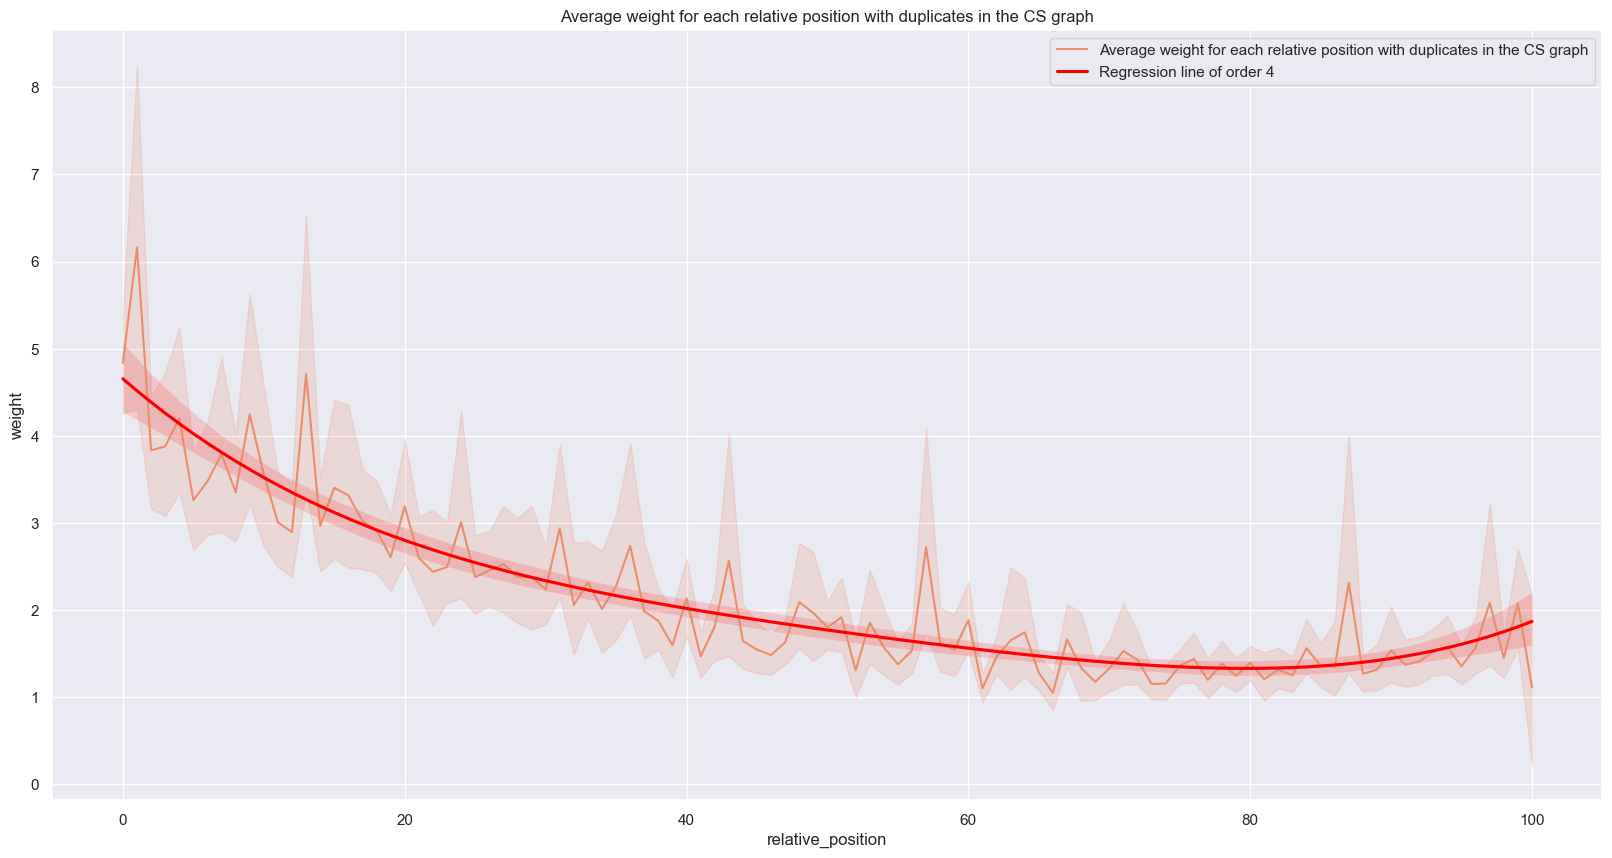

In [15]:
# plot average weight for each relative_position_duplicates
plt.figure(figsize=(20,10))
# Plot the average weight for each relative position without duplicates in the CS graph
sns.lineplot(x=filtred_links_df.relative_position, y=filtred_links_df.weight, data=filtred_links_df, label="Average weight for each relative position with duplicates in the CS graph",legend='full', errorbar=('ci', 95) )
# Add regression line
sns.regplot(x=filtred_links_df.relative_position, y=filtred_links_df.weight, data=filtred_links_df, scatter=False, color="red", label="Regression line of order 4", order= 4)
# legend for ci 
plt.legend(loc='upper right')
plt.title("Average weight for each relative position with duplicates in the CS graph")
plt.show()

We can clearly see a downtrend of the weight as a function of the relative position of the link inside the articles.<br>

Links at the beginning of the article are **3 times** more likely to be clicked on than links at later stage of the article : The average weight of a link at around the 1st percentage of the article $\simeq 4,5$ , while it is $\simeq 1,5$ at 80% of the article. <br>
&rarr; This means that links in the beginning of the article are more likely to be clicked on. <br>

This clearly shows that the relative position of the link in the article is determinant on whether the user will click on it or not.


##### **4.2. How does the proportion of clicked links evolve with number of exiting links in an article?** <br>

Let's get back to our `links_df` dataframe. <br>

In [16]:
links_df.sample(5)

,From,To,positions,nb_links,weight
47409,H5N1,Evolution,[2],43,2
90800,Regent%27s_Park,Hyde_Park%2C_London,[],9,1
234,12th_century,Ireland,[16],52,1
5241,Algiers,Russia,[42],57,1
46292,Great_Spotted_Woodpecker,Carolus_Linnaeus,[5],12,0


We can also forget about the `positions` and `weight` attribute since it is not relevant for our analysis. <br>

Morover we also drop the `nb_links` attribute since we will no longuer be intrested in the total number of links in the article, but by the number of different links in it. <br>

Thus we difine `nb_diff_links` and `nb_explored_links` which will enable us to get to the proportion of explored links `prop_explored`  <br>

In [17]:
# define filtred links df as copy of links_df
filtred_links_df = links_df.copy()
# Get rid of the positions column
filtred_links_df.drop(columns=['positions'], inplace=True)
filtred_links_df.drop(columns=['nb_links'], inplace=True)

In [18]:
filtred_links_df.sample(5)

,From,To,weight
113180,Ununtrium,List_of_elements_by_name,1
53283,Hurricane_John_%282006%29,United_States,4
20765,Capital,Salt_Lake_City%2C_Utah,4
53171,Hurricane_Edouard_%281996%29,Bermuda,0
27130,Cornell_University,United_States_Congress,0


In [19]:
# add a column nb_diff_links which count number of unique to for each from
filtred_links_df['nb_diff_links'] = filtred_links_df.groupby('From')['To'].transform('nunique')
filtred_links_df.sample(5)

,From,To,weight,nb_diff_links
36169,English_monarchs_family_tree,William_I_of_England,0,3
25790,Comics,Brush,2,25
80568,Ocean,Continent,19,43
118723,Yeast,Beer,7,42
118629,Yagan,Folklore,1,19


In [20]:
# Drop unexplored links
filtred_links_df = filtred_links_df[filtred_links_df['weight'] != 0]

In [21]:
# group by from and count the number of unique to 
filtred_links_df = filtred_links_df.groupby('From').agg({'To': 'nunique', 'nb_diff_links': 'first'})
# rename the column To to nb_explored_links
filtred_links_df.rename(columns={'To': 'nb_explored_links'}, inplace=True)
# Add a column with the ratio of explored links
filtred_links_df['prop_explored'] = filtred_links_df.apply(lambda row: int(round(row['nb_explored_links']/row['nb_diff_links'],2)*100), axis=1)

In [22]:
#print the number of articles in the dataframe
print("Number of articles in the dataframe with atleast one explored link: ", len(filtred_links_df))
filtred_links_df.sample(5)

Number of articles in the dataframe with atleast one explored link:  4176


,nb_explored_links,nb_diff_links,prop_explored
From,,,
The_Rolling_Stones,19,32,59
Coconut_crab,14,33,42
Europe,147,159,92
Russia,97,105,92
Scottish_mythology,6,7,86


To get a better understanding of the data, we plot the distribution of nb_diff_links in the article. <br>

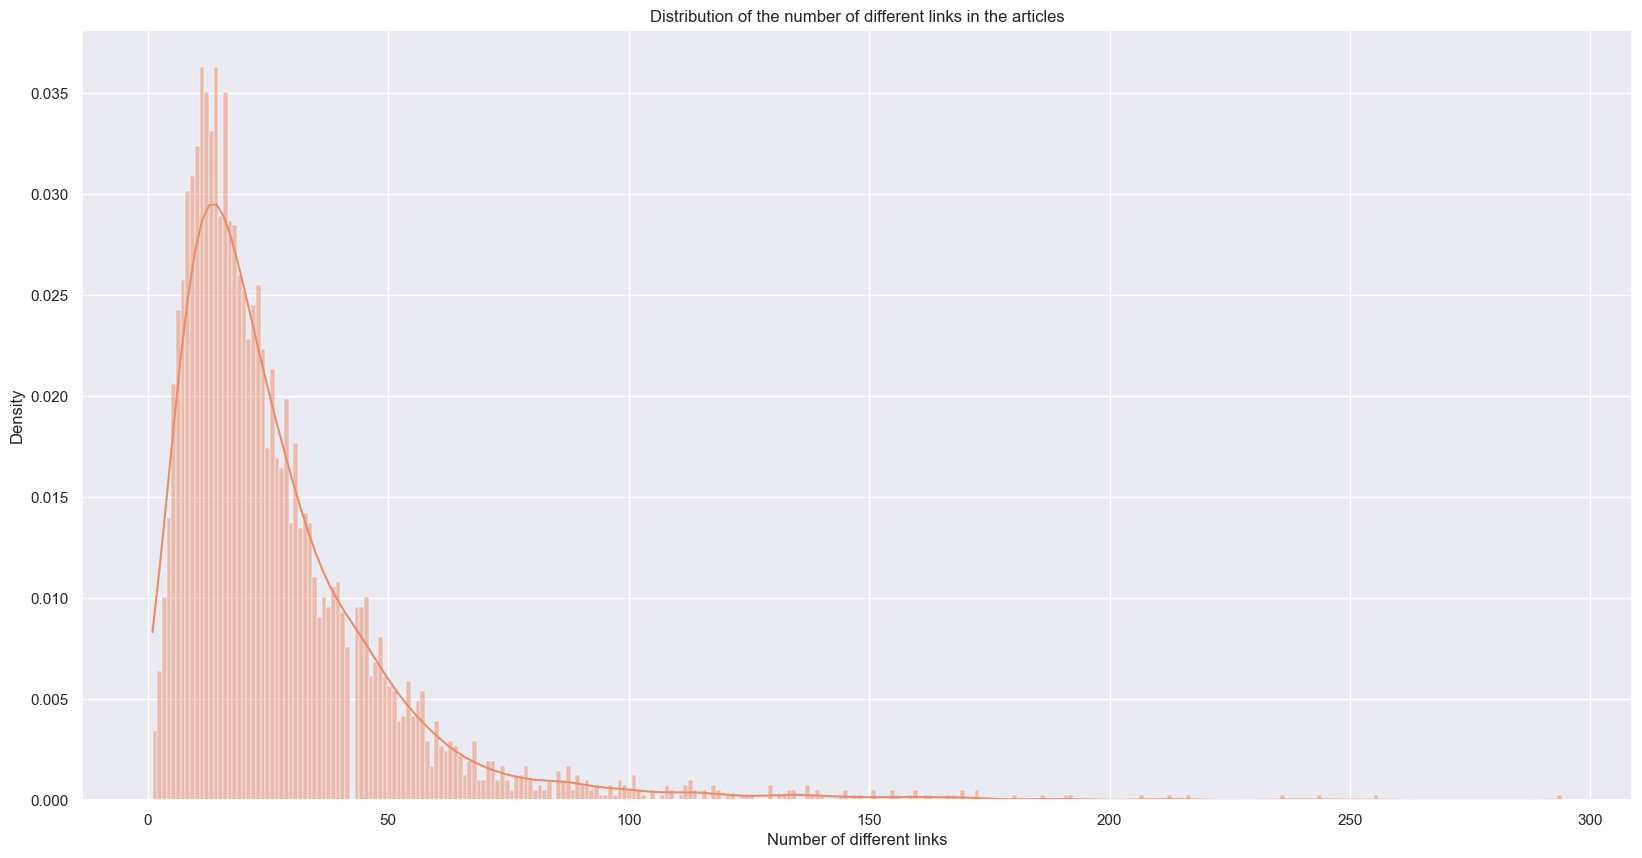

In [23]:
plt.figure(figsize=(20,10))
sns.histplot(filtred_links_df['nb_diff_links'], bins=300 , kde=True, stat='density', label="Distribution of the number of links in articles")
plt.title("Distribution of the number of different links in the articles")
plt.xlabel("Number of different links")
plt.ylabel("Density")
plt.show()

The number of links distribution in articles is skewed to the right. The majority of articles have less than 50 different links. We now have to check if the extreme values are relevant or not. <br>

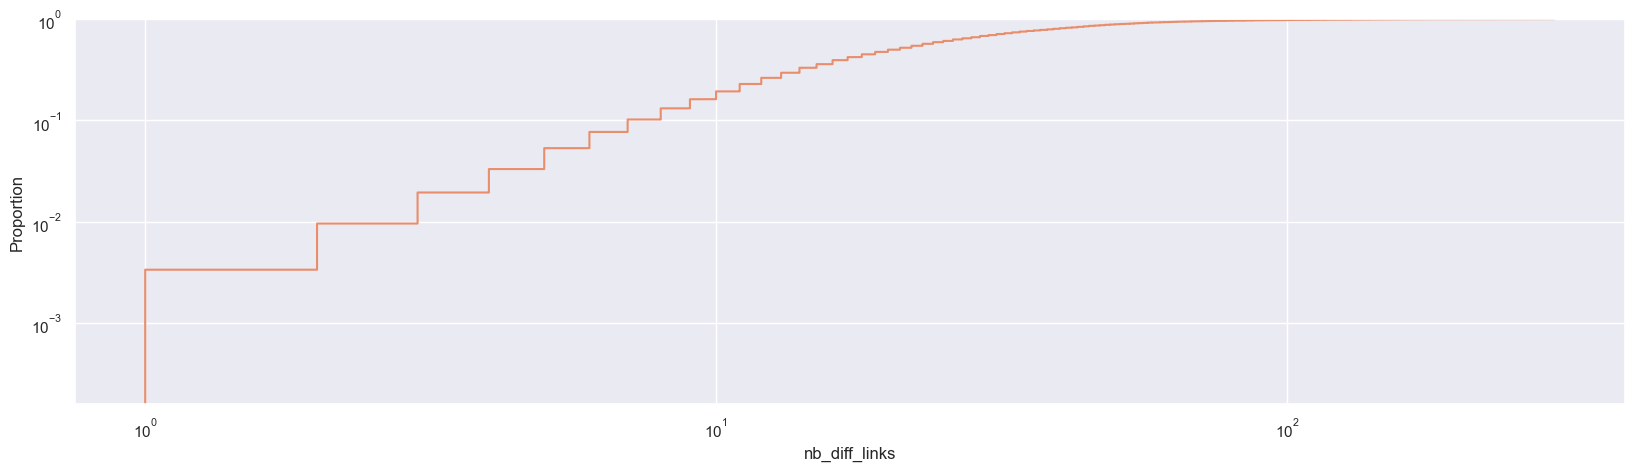

In [24]:
plt.figure(figsize=(20,5))
sns.ecdfplot(data=filtred_links_df, x='nb_diff_links')
plt.xscale('log')
plt.yscale('log')

We can see that the distribution of the number of different links is not heavy tailed, so we can get rid of the outliers. We choose to keep 95% of the data <br>

In [25]:
# keep only 95% of the articles with the less links
filtred_links_df = filtred_links_df[filtred_links_df['nb_diff_links'] < filtred_links_df['nb_diff_links'].quantile(0.95)]

In [26]:
#qort the dataframe by nb_diff_links
filtred_links_df.sort_values(by=['nb_diff_links'], inplace=True, ascending=False)

We plot the same distribution after filtering:

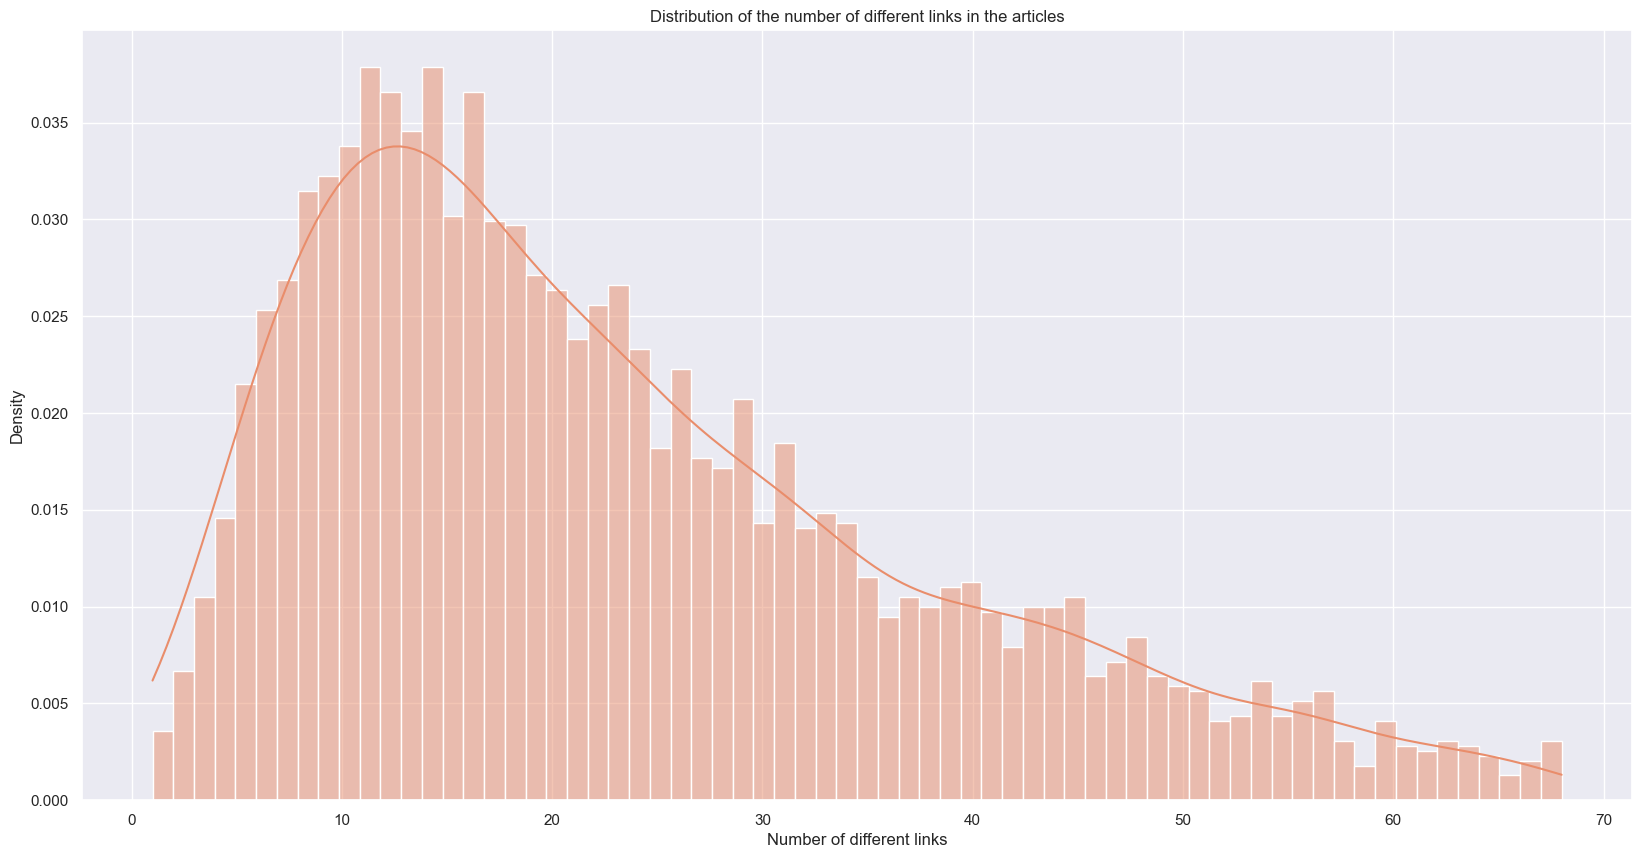

In [27]:
plt.figure(figsize=(20,10))
sns.histplot(filtred_links_df['nb_diff_links'], bins=68 , kde=True, stat='density', label="Distribution of the number of links in articles")
plt.title("Distribution of the number of different links in the articles")
plt.xlabel("Number of different links")
plt.ylabel("Density")
plt.show()

Let's examine the relationship between the number of different links and the proportion of explored links. <br>

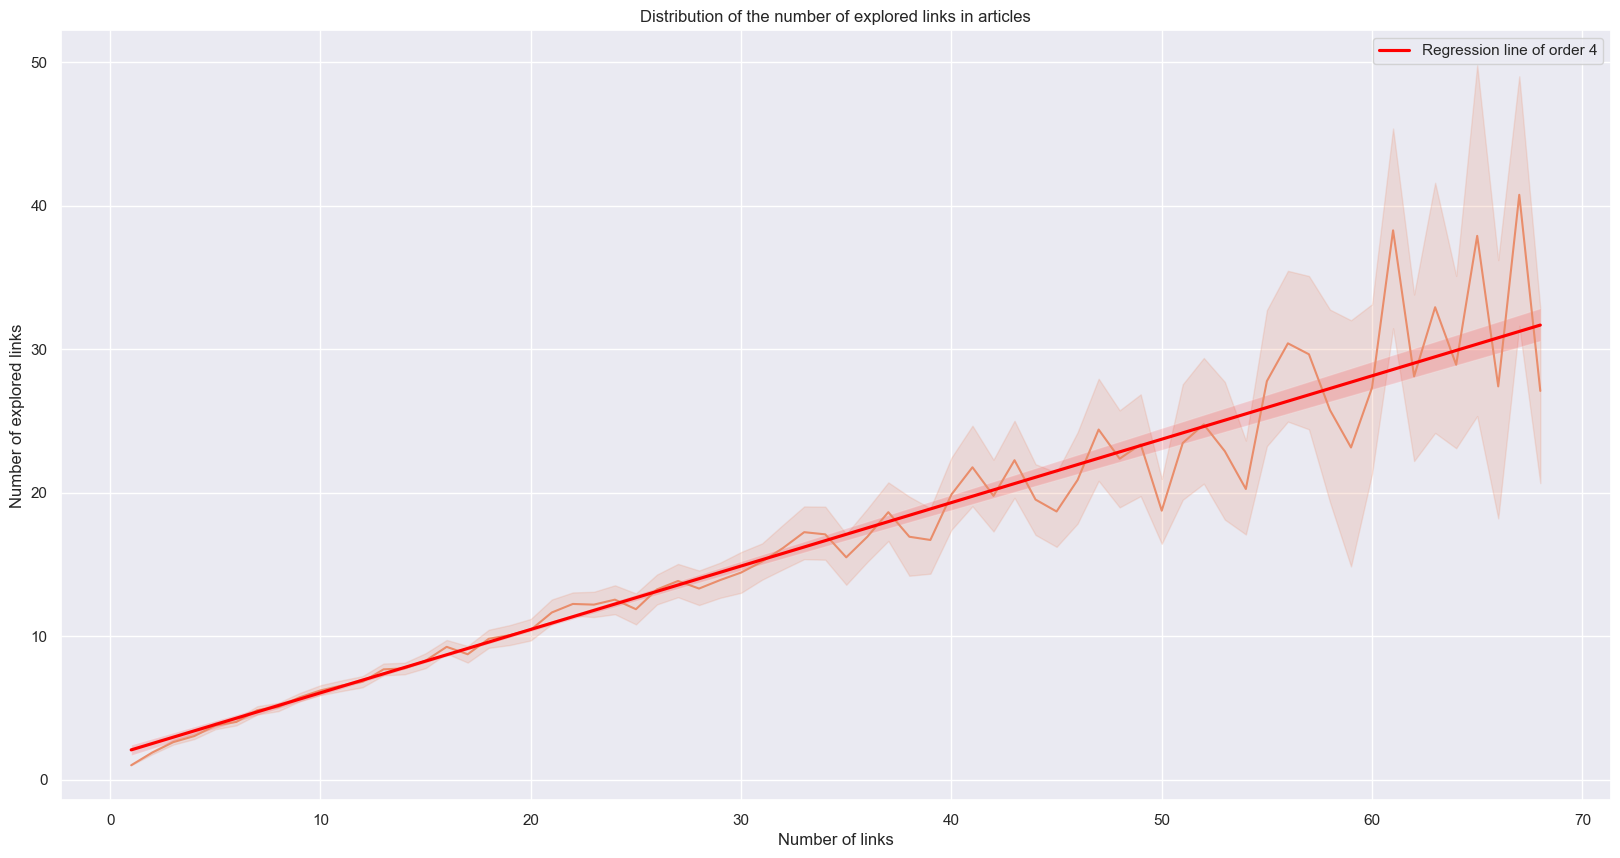

In [82]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=filtred_links_df, x="nb_diff_links", y="nb_explored_links", errorbar=('ci',90))
sns.regplot(data=filtred_links_df, x="nb_diff_links", y="nb_explored_links", scatter=False, color="red", label="Regression line of order 4", order= 1)
plt.title("Distribution of the number of explored links in articles")
plt.legend()
plt.xlabel("Number of links")
plt.ylabel("Number of explored links")
plt.show()

In [29]:
# Linear regression to determine the sloap of the regression line
mod = smf.ols(formula='nb_explored_links ~   nb_diff_links', data=filtred_links_df)
res = mod.fit()
print(res.params)

Intercept        1.630162
nb_diff_links    0.441796
dtype: float64


We can clearly distinguis a linear relationship between the number of different links and the proportion of explored links :on avearge, people explore $\simeq 45$% of the links in an article. <br>

Let's see how this proportion evolves with the number of different links in an article. <br>

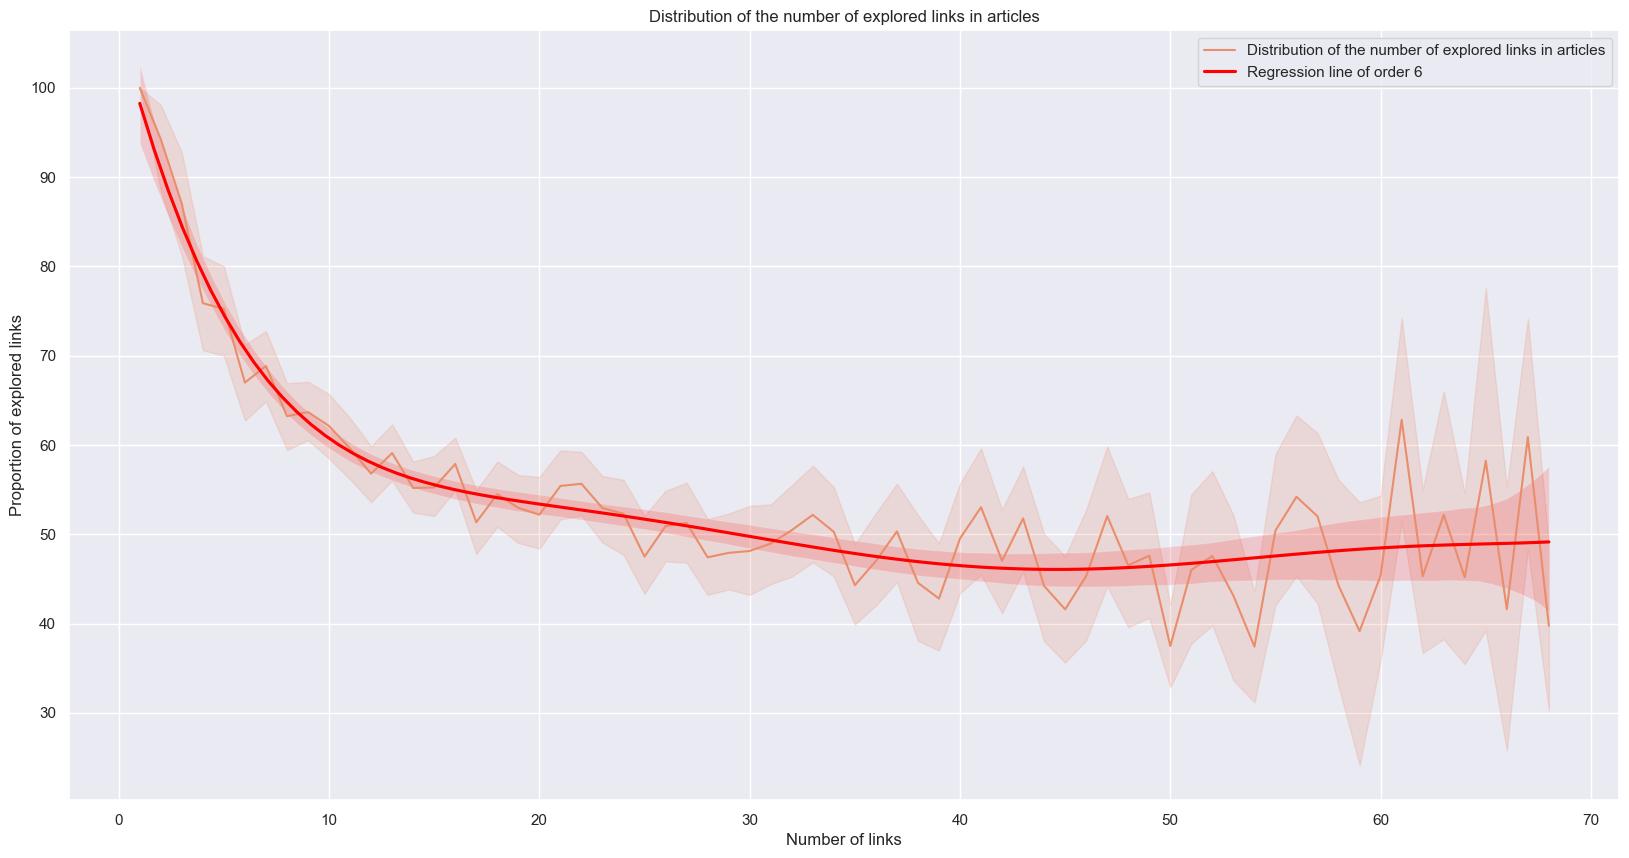

In [84]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=filtred_links_df, x="nb_diff_links", y="prop_explored", label="Distribution of the number of explored links in articles", errorbar=('ci',90))
sns.regplot(data=filtred_links_df, x="nb_diff_links", y="prop_explored", scatter=False, color="red", label="Regression line of order 6", order= 6, ci=90)
plt.title("Distribution of the number of explored links in articles")
plt.legend()
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()

@TODO : explain

---
---

### **5. How good are the discussed parameters to predict human behavior?**

Until now we discussed 2 main parameters that can explain why people click on a link or not : <br>
- **Semantic similarity** between the link and the target. <br>
- **Topology of the article** with the positionning of the links and their number. <br>


Now, we will try to see how accurate are these paramters to determine whether a link will be clicked on or not. <br>

We will construct a datafame that compiles actual game situations where a user was in an article that had a link to the target article. <br> 
- Success events will be labeled as `1` and will correspond to the last transition in all finished paths. <br>
- Failure events will be labeled as `0` and will correspond to the compilation of links in paths that had a link to the target article but were not clicked . <br>

Again, we will need our `links_df` dataframe to get the position of the link in the article as weel as the df_paths_finished. <br>

In [31]:
links_df.sample(5)

,From,To,positions,nb_links,weight
64850,List_of_Oceanian_countries,New_Caledonia,[12],40,0
56203,Iron,Mammal,[91],92,6
70856,Mauritius,Tourism,[26],52,0
87252,Politics,Liberalism,[58],90,0
24377,City_status_in_the_United_Kingdom,Aberdeen,[36],79,0


In [32]:
#set From and To as index
links_df.set_index(['From','To'], inplace=True)

In [33]:
with open('data/df_paths_finished.pickle', 'rb') as handle:
    df_paths_finished = pickle.load(handle)
df_paths_finished.sample(5)

,path,start,end,length,article_similarity,title_similarity
29765,"[Brahman, Hindi, India, Flag_of_India, Mahatma...",Brahman,Flag_of_South_Africa,7,"[0.58, 0.63, 0.6, 0.77, 0.64, 0.66, 1.0]","[0.37, 0.31, 0.42, 0.58, 0.41, 0.89, 1.0]"
1690,"[Beer, Water, Earth, Sun]",Beer,Sun,4,"[0.49, 0.59, 0.89, 1.0]","[0.51, 0.62, 0.59, 1.0]"
663,"[Archbishop_of_Canterbury, Christianity, Relig...",Archbishop_of_Canterbury,Universe,5,"[0.54, 0.52, 0.47, 0.52, 1.0]","[0.51, 0.47, 0.57, 0.66, 1.0]"
11903,"[United_States_Senate, Latin, 1st_century_BC, ...",United_States_Senate,3rd_century,6,"[0.63, 0.61, 0.78, 0.78, 0.74, 1.0]","[0.25, 0.54, 0.7, 0.68, 0.74, 1.0]"
1542,"[Batman, Scotland, United_Nations, United_Stat...",Batman,Bible,13,"[0.55, 0.55, 0.55, 0.59, 0.59, 0.58, 0.59, 0.5...","[0.41, 0.48, 0.5, 0.51, 0.44, 0.36, 0.51, 0.47..."


We will now combine the informations for boath links_df and df_paths_finished to get the `missed_winning_link` and `found_winning_link` dataframe.<br>
Each row of the dataframe will contain the following informations: <br>
- `article`: the article from which the winning link appears <br>
- `target`: the target article <br>
- `article_similarity`: semantic similarity between the content of the two articles <br>
- `title_similarity`: semantic similarity between the titles of the two articles <br>
- `link_position`: the position of the link in the article <br>
- `nb_links`: the number of links in the article <br> 


In [34]:
# We create a dataframe to store the missed winning occasions
missed_winning_link = pd.DataFrame(columns=['article', 'target', 'article_similarity', 'title_similarity', 'link_position', 'nb_links' ])
counter_not_found = 0
# We create a dataframe to store the found winning occasions
found_winning_link = pd.DataFrame(columns=['article', 'target', 'article_similarity', 'title_similarity', 'link_position', 'nb_links'])
counter_found = 0

# We iterate over the paths
for i in range(len(df_paths_finished)):
    # define the target article
    target_article =  df_paths_finished.iloc[i,2]
    # get the path from the dataframe
    path = df_paths_finished.iloc[i,0]
    # get the similarity of the articles array
    path_sim_article = df_paths_finished.iloc[i,4]
    # get the similarity of the titles array
    path_sim_title = df_paths_finished.iloc[i,5]

    # For each article in the path
    for j in range(len(path)-1): 
        # If there exists a link between the article and the target article
        if target_article in truth_graph.matrix_articles[path[j]].keys():
            
            # get the position of the link
            position = links_df.loc[path[j], target_article]['positions']
            # get the number of links in the article
            nb_links = links_df.loc[path[j], target_article]['nb_links']

            # Tretment for found_winning_link
            if j == len(path)-2 :
                found_winning_link.loc[counter_found] = [path[j], target_article, path_sim_article[j], path_sim_title[j], position, nb_links ]
                counter_found = counter_found +1 
            # Tretment for missed_winning_link
            else :
                # iterate over all positions with index
                for i, index in enumerate(position):
                    missed_winning_link.loc[counter_not_found] = [path[j], target_article, path_sim_article[j], path_sim_title[j], index, nb_links]
                    counter_not_found = counter_not_found+1

In [35]:
print("Number of missed winning links : ", len(missed_winning_link))
missed_winning_link.sample(5)

Number of missed winning links :  10894


,article,target,article_similarity,title_similarity,link_position,nb_links
3836,Communism,Marxism,0.78,0.82,1,84
8267,Prime_Minister_of_the_United_Kingdom,Gordon_Brown,0.67,0.39,43,52
5985,Canada,National_Hockey_League,0.79,0.62,74,82
5345,Venus,Mars,0.92,0.84,47,73
44,United_Kingdom,England,0.91,0.83,230,249


In [36]:
print("Number of found winning links : ", len(found_winning_link))
found_winning_link.sample(5)

Number of found winning links :  42254


,article,target,article_similarity,title_similarity,link_position,nb_links
32481,Christianity,Roman_Catholic_Church,0.86,0.72,"[43, 58, 59, 66]",67
27352,Cell_%28biology%29,Microscope,0.66,0.48,[40],44
21343,Protein,Enzyme_kinetics,0.82,0.66,"[18, 21]",35
2189,Rainforest,Indonesia,0.52,0.46,[8],34
33437,Pacific_Ocean,New_Zealand,0.61,0.58,"[37, 92]",117


When the winning link appears in different positions in the article, since we do not know which of the positions was clicked, we will discard the entire article from our compilation so that we do not have any bias.<br>

In [37]:
#keep only rows where link_position is of length 1
found_winning_link = found_winning_link[found_winning_link['link_position'].apply(lambda x: len(x) == 1)]
# convert link_position to int
found_winning_link['link_position'] = found_winning_link['link_position'].apply(lambda x: x[0]) 


In [38]:
print("Number of found winning links : ", len(found_winning_link))

Number of found winning links :  21620


Finally we downsample the `found_winning_link`  dataframe to have the same number of rows as `missed_winning_link` the  dataframe. <br>

In [39]:
# We down sample the missed_winning_link dataframe to have the same number of rows as the found_winning_link dataframe
found_winning_link = found_winning_link.sample(len(missed_winning_link))
print("Number of found winning links : ", len(found_winning_link))
found_winning_link.sample(5)

Number of found winning links :  10894


,article,target,article_similarity,title_similarity,link_position,nb_links
17454,Dinosaur,Cretaceous-Tertiary_extinction_event,0.71,0.49,73,151
14987,Canada,Christianity,0.63,0.38,64,82
19631,Hydrogen,Atom,0.83,0.83,22,78
17901,Earth,Pluto,0.89,0.71,147,163
4651,Ancient_Greece,Minoan_civilization,0.90,0.71,19,95


In [40]:
for column in ['article_similarity', 'title_similarity', 'link_position', 'nb_links']:
    print("Average ", column , " in found_winning_link vs missed_winning_link: ", round(np.mean(found_winning_link[column]), 2), round(np.mean(missed_winning_link[column]), 2))
    print("Median ", column , " in found_winning_link vs missed_winning_link: ", round(np.median(found_winning_link[column]), 2), round(np.median(missed_winning_link[column]), 2))
    print()

Average  article_similarity  in found_winning_link vs missed_winning_link:  0.69 0.7
Median  article_similarity  in found_winning_link vs missed_winning_link:  0.7 0.7

Average  title_similarity  in found_winning_link vs missed_winning_link:  0.61 0.59
Median  title_similarity  in found_winning_link vs missed_winning_link:  0.61 0.59

Average  link_position  in found_winning_link vs missed_winning_link:  40.41 94.56
Median  link_position  in found_winning_link vs missed_winning_link:  25.0 61.0

Average  nb_links  in found_winning_link vs missed_winning_link:  93.93 175.94
Median  nb_links  in found_winning_link vs missed_winning_link:  66.0 125.0



We can now create a new dataframe `games_df` that combines both `found_winning_link` and `missed_winning_link` dataframes. <br>

In [41]:
# Add label to the dataframes
found_winning_link['label'] = 1
missed_winning_link['label'] = 0

# Concatenate the dataframes
games_df = pd.concat([found_winning_link, missed_winning_link], ignore_index=True)
print("Size of the dataframe: ", len(games_df))
games_df.sample(5)

Size of the dataframe:  21788


,article,target,article_similarity,title_similarity,link_position,nb_links,label
15962,United_States,United_States_Senate,0.64,0.56,224,423,0
11072,South_America,Ecuador,0.68,0.58,80,216,0
14257,Geology,Volcano,0.78,0.65,21,37,0
5372,British_Isles,Isle_of_Wight,0.69,0.66,21,110,1
14406,French_language,Monaco,0.71,0.47,5,110,0


Finally we can train a `Random Forest Classifier` on the `article_similarity`, `title_similarity`, `link_position` and 	`nb_links` attributes to predict whether the user will click on the link or not. <br>

In [89]:
# create a random forest classifier that uses the article similarity, title similarity, position of article in path and position of link in article to predict label
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=3)
features = ['article_similarity', 'title_similarity', 'link_position', 'nb_links']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(games_df[features], games_df['label'], test_size=0.2, random_state=0)

# train the classifier
clf.fit(X_train, y_train)

# print the accuracy of the classifier
print("Accuracy: ", round(clf.score(X_test, y_test),2)*100, "%")

importances = clf.feature_importances_
# get indices of the most important features
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(features)):
    print("%d.  %s (%f)" %  round((f + 1, features[indices[f]], importances[indices[f]]),2))

Accuracy:  79.0 %
Feature ranking:


TypeError: type tuple doesn't define __round__ method

We can conclude the chosen metrics are good predictors of human behavior since we correctly guess if the article is found 80% of the times! <br>

We note that the semantic similarity between the content of the article and the target article is a less important factor than the article topology in determining whether a link will be clicked on or not. (40% vs 60%) <br>


### **6. Recommendation**

In [45]:
article_list= truth_graph.articles

In [46]:
# create a df with path, start, end, length
df_paths_unfinished = pd.DataFrame(columns=['path', 'start', 'end', 'length'])
counter = 0

# chek that a list of string named articles contains all elements list of string named list2
def contains_all(articles, path):
    for element in path:
        if not articles.__contains__(element):
            return False
    return True

with open("data/paths_unfinished.tsv",encoding="utf8") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for line in tsv_file:
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else:   
                    path = line[3].split(';')
                    if path.__contains__('<') or path.__contains__('Pikachu') or line[4]=='Pikachu' or not contains_all(article_list, path) or not article_list.__contains__(line[4]):
                        continue
                    
                    start = path[0]
                    end = line[4]
                    length = len(path)
                    df_paths_unfinished.loc[counter] = [path, start, end, length]
                    counter += 1
df_paths_unfinished
# drop paths of length 1
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['length'] > 1]
df_paths_unfinished['article_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
df_paths_unfinished['title_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.6, 0.5, 0.7]","[0.39, 0.36, 0.5]"
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.61, 0.66]","[0.43, 0.47]"
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.28, 0.62, 0.59, 0.79]","[0.18, 0.37, 0.76, 0.56]"
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.48, 0.51, 0.37, 0.5, 0.42, 0.41, 0.36]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]"
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.49, 0.62, 0.39, 0.64, 0.65]","[0.45, 0.3, 0.34, 0.57, 0.29]"
...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.63, 0.67, 0.66, 0.61, 0.76, 0.84, 0.9]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]"
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.38, 0.71, 0.75]","[0.22, 0.4, 0.75]"
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.55, 0.62, 0.76, 0.65, 0.8, 0.74]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]"
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.58, 0.62, 0.6, 0.54]","[0.41, 0.6, 0.41, 0.41]"


In [78]:
# if first element of article_similarity > last element of article_similarity +/- 0.1, 0 else 1
df_paths_unfinished['label_article'] = df_paths_unfinished.apply(lambda row: 0 if row['article_similarity'][0] > row['article_similarity'][-1]- 0.1 else 1, axis=1)
# if first element of title_similarity > last element of title_similarity +/- 0.1, 0 else 1
df_paths_unfinished['label_title'] = df_paths_unfinished.apply(lambda row: 0 if row['title_similarity'][0] > row['title_similarity'][-1]- 0.1 else 1, axis=1)

In [79]:
# show proportion of 0 and 1 in label_article in percentage
df_paths_unfinished['label_article'].value_counts(normalize=True)*100



0    61.304711
1    38.695289
Name: label_article, dtype: float64

In [80]:
# get rid of paths of length > 20
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['length'] < 20]

<AxesSubplot: xlabel='length', ylabel='Count'>

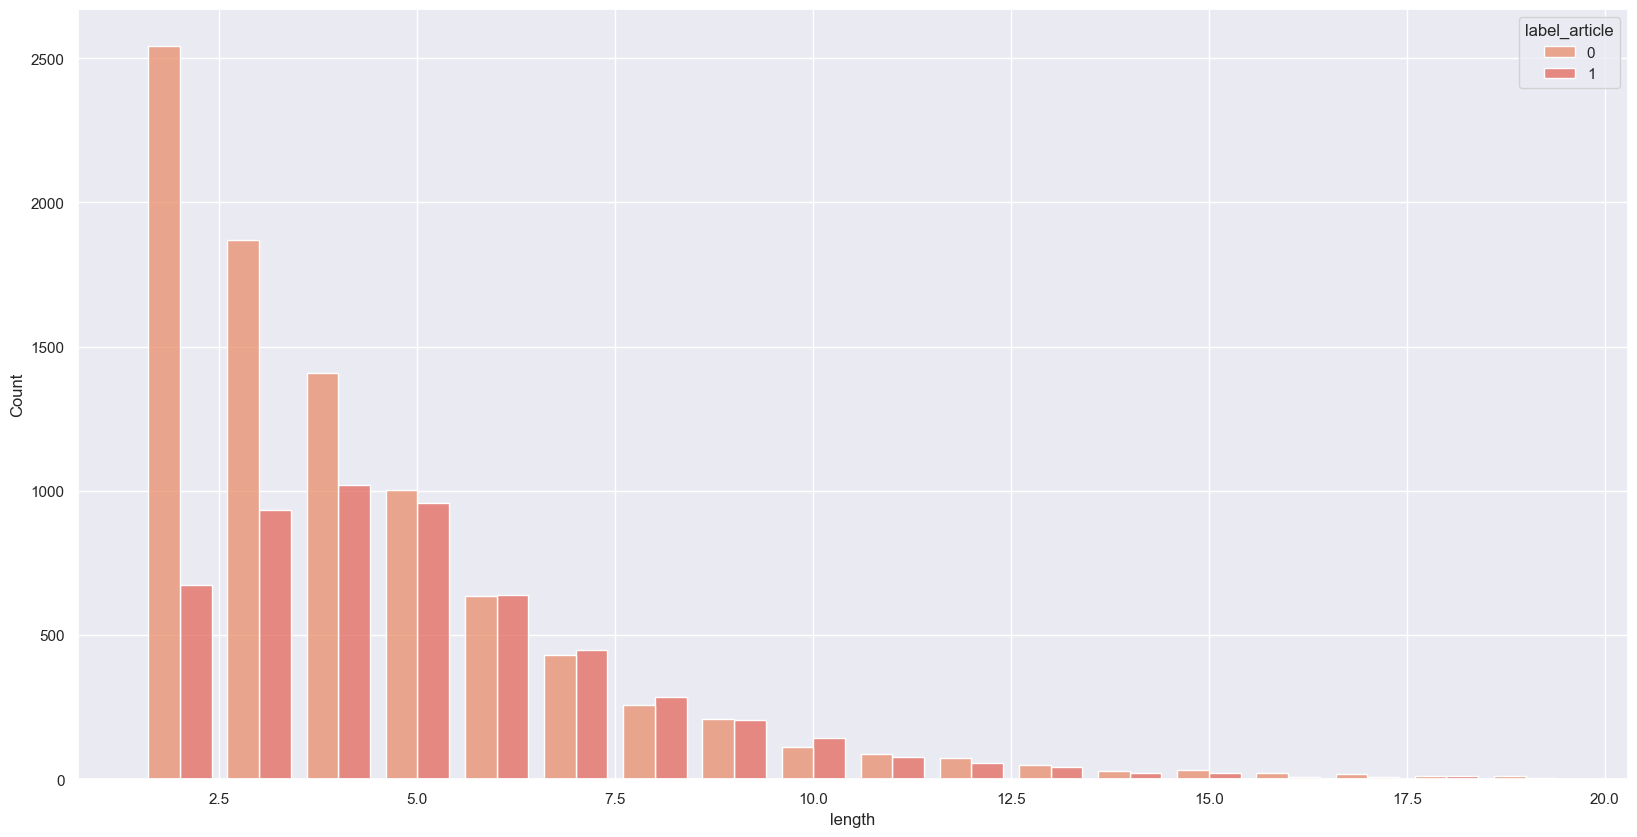

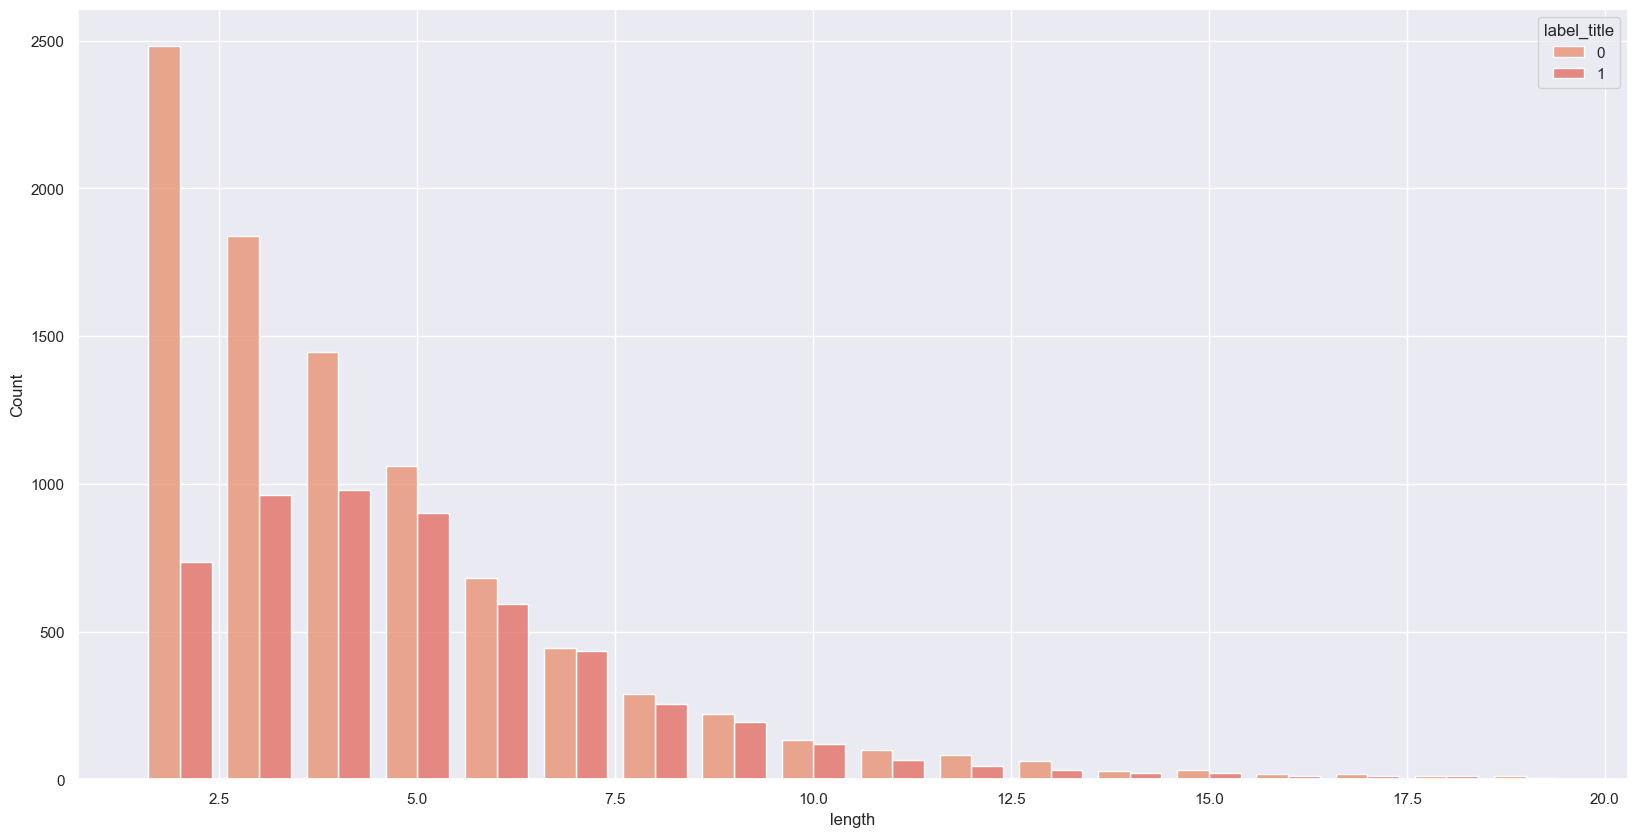

In [81]:
# path length distribution as a function of label_article
plt.figure(figsize=(20,10))
sns.histplot(data=df_paths_unfinished, x="length", hue="label_article", multiple="dodge", bins=19, shrink=0.8, discrete=True)
# path length distribution as a function of label_article
plt.figure(figsize=(20,10))
sns.histplot(data=df_paths_unfinished, x="length", hue="label_title",  multiple="dodge", bins=19, shrink=0.8, discrete=True)